# Prep my data for offline flux calculation

In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

## Load merged, preprocessed atmos and ocean data

In [3]:
ds_merged = preprocess_data()
ds_merged

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Process data for future flux check

In [59]:
ds_in = ds_merged
ds_in = ds_in.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])

#take a sample of the earth for analysis
ds_highRes = ds_in.isel(time = slice(0,365))  
ds_highRes

<xarray.Dataset> Size: 156GB
Dimensions:       (time: 365, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

### Heat flux

In [41]:
import aerobulk
from aerobulk import noskin

ql, qh, taux, tauy, evap =  noskin(
        ds_highRes.surface_temp,
        ds_highRes.t_ref,
        ds_highRes.q_ref,
        ds_highRes.u_relative,
        ds_highRes.v_relative,
        slp=ds_highRes.slp,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatfluxHR = qh + ql
heatfluxHR

<xarray.DataArray (time: 365, yt_ocean: 2700, xt_ocean: 3600)> Size: 14GB
dask.array<add, shape=(365, 2700, 3600), dtype=float32, chunksize=(3, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

In [72]:
from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=4, threads_per_worker=2) #default: n_workers=4, threads_per_worker=1
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/panalluri/proxy/40097/status,
Dashboard: /user/panalluri/proxy/40097/status,Workers: 4
Total threads: 8,Total memory: 125.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37279,Workers: 4
Dashboard: /user/panalluri/proxy/40097/status,Total threads: 8
Started: Just now,Total memory: 125.80 GiB
Comm: tcp://127.0.0.1:34165,Total threads: 2
Dashboard: /user/panalluri/proxy/35995/status,Memory: 31.45 GiB
Nanny: tcp://127.0.0.1:36413,


In [43]:
# prepare code for comparison w CM2.6 online flux
# TODO. Weight by grid_area

HF_spatialAvg = heatfluxHR.mean(dim=["xt_ocean", "yt_ocean"]).load()
HF_spatialAvg

<xarray.DataArray (time: 365)> Size: 1kB
array([-152.13904 , -159.24268 , -158.89911 , -157.12566 , -159.64311 ,
       -158.75809 , -161.69981 , -161.45726 , -156.69522 , -163.14787 ,
       -170.81801 , -170.33583 , -169.69972 , -173.18024 , -173.59727 ,
       -176.1592  , -168.70027 , -172.18535 , -170.58194 , -164.98582 ,
       -160.83353 , -163.11426 , -165.03421 , -158.80534 , -158.12921 ,
       -155.20198 , -152.66028 , -155.68523 , -158.14682 , -162.84679 ,
       -161.96643 , -165.51965 , -176.83325 , -177.2838  , -165.44463 ,
       -152.16246 , -147.1771  , -150.80849 , -153.11662 , -153.98299 ,
       -159.08434 , -160.86554 , -159.9962  , -160.30748 , -160.35939 ,
       -163.755   , -170.09576 , -177.37294 , -175.74994 , -178.73807 ,
       -178.73195 , -174.2035  , -169.44199 , -168.56206 , -167.7262  ,
       -166.44905 , -169.48433 , -178.86932 , -174.69476 , -172.7956  ,
       -170.75215 , -168.0752  , -163.23085 , -161.80414 , -165.13626 ,
       -172.2716  , -173.70802 , -164.98106 , -164.21207 , -167.95113 ,
       -170.87048 , -164.6139  , -165.18411 , -162.75467 , -161.61688 ,
       -162.67604 , -168.14856 , -180.52997 , -179.79019 , -167.66127 ,
       -164.43172 , -168.98631 , -168.28105 , -151.43242 , -139.9548  ,
       -142.2571  , -145.26468 , -148.0717  , -151.06555 , -144.83212 ,
       -137.30086 , -129.73218 , -135.05652 , -136.65077 , -134.80554 ,
       -142.20099 , -149.93547 , -150.11447 , -144.61879 , -144.29597 ,
...
       -129.68036 , -127.42131 , -127.20261 , -127.048004, -130.35794 ,
       -129.62788 , -132.96326 , -126.65996 , -116.418434, -117.68011 ,
       -126.22531 , -130.32294 , -128.57542 , -126.666595, -128.98853 ,
       -130.72395 , -136.01561 , -135.6095  , -132.27975 , -128.84726 ,
       -134.09811 , -144.16866 , -145.76749 , -145.78195 , -143.87569 ,
       -148.46576 , -156.8221  , -152.57947 , -148.38644 , -150.66101 ,
       -149.48851 , -146.67543 , -142.43326 , -142.17877 , -148.11473 ,
       -148.65103 , -154.20796 , -149.47394 , -147.37326 , -147.48296 ,
       -142.8915  , -150.6654  , -154.17693 , -150.76453 , -144.42668 ,
       -140.51796 , -143.78386 , -136.88786 , -130.30055 , -132.33849 ,
       -143.91795 , -142.99695 , -137.55673 , -131.39055 , -131.07419 ,
       -139.30206 , -147.94174 , -156.12143 , -158.68427 , -149.66878 ,
       -143.81638 , -145.09358 , -143.43097 , -143.81499 , -139.8374  ,
       -143.78926 , -151.6737  , -168.52745 , -176.16434 , -172.04076 ,
       -170.07559 , -165.24643 , -153.68307 , -148.54366 , -144.87726 ,
       -143.27968 , -140.28455 , -137.19374 , -146.6043  , -144.94926 ,
       -141.506   , -141.2148  , -147.56952 , -154.32077 , -152.62318 ,
       -149.86557 , -143.12099 , -134.67017 , -133.55788 , -139.48596 ,
       -134.56036 , -131.51181 , -139.97816 , -146.85318 , -145.62198 ],
      dtype=float32)
Coordinates:
  * time     (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00

In [44]:
import gcsfs
import os
import xarray as xr

HF_spatialAvg.to_zarr('gs://leap-persistent/panalluri/HF_spatialAvg_pointwiseGlobe.zarr')  

### Momentum flux

In [73]:
momfluxHR = np.sqrt( (taux ** 2 + tauy ** 2) )
MF_spatialAvg = momfluxHR.mean(dim=["xt_ocean", "yt_ocean"]).load()
MF_spatialAvg

<xarray.DataArray (time: 365)> Size: 1kB
array([0.11101727, 0.12213524, 0.11839753, 0.11315187, 0.11744437,
       0.12055379, 0.11932565, 0.11511422, 0.10838071, 0.11343449,
       0.1183823 , 0.12138962, 0.11464971, 0.1126485 , 0.12497162,
       0.12919724, 0.12846406, 0.13349175, 0.12556636, 0.11182985,
       0.10267709, 0.10952637, 0.11442751, 0.11885294, 0.11872907,
       0.11322397, 0.10660712, 0.10526679, 0.10414077, 0.112624  ,
       0.1176063 , 0.11893873, 0.12800929, 0.13286899, 0.12938353,
       0.11234519, 0.1077671 , 0.11334493, 0.11367574, 0.12032488,
       0.11694578, 0.11155068, 0.11212983, 0.10644539, 0.10681328,
       0.10753617, 0.1099406 , 0.11795636, 0.12352999, 0.12609614,
       0.12143596, 0.11516301, 0.11247449, 0.11346092, 0.11780208,
       0.10836571, 0.10826957, 0.11241934, 0.11123449, 0.12038025,
       0.11674517, 0.11868359, 0.11694918, 0.11784285, 0.12305512,
       0.12624563, 0.12658074, 0.13053861, 0.13303539, 0.13851507,
       0.13806625, 0.12899205, 0.1282345 , 0.11861991, 0.10965757,
       0.10932636, 0.11795595, 0.1304779 , 0.13163307, 0.13319898,
       0.12644045, 0.12395959, 0.13356811, 0.1307106 , 0.12130313,
       0.12295682, 0.12356263, 0.12628819, 0.12712651, 0.1164418 ,
       0.10553982, 0.10991591, 0.11480021, 0.11166447, 0.10656692,
       0.1156619 , 0.12040322, 0.11289385, 0.11103035, 0.12099671,
...
       0.12364732, 0.12705655, 0.13965142, 0.14202738, 0.13381164,
       0.13523279, 0.1361557 , 0.12581101, 0.11834483, 0.12333247,
       0.13197397, 0.13295776, 0.12925865, 0.12291379, 0.12149593,
       0.11561202, 0.11586203, 0.11508923, 0.11532891, 0.11378261,
       0.12219246, 0.13148072, 0.12787765, 0.12214545, 0.11799189,
       0.13026781, 0.14452328, 0.14130656, 0.13381754, 0.13727762,
       0.13585012, 0.13677332, 0.12816219, 0.124788  , 0.12752245,
       0.1261966 , 0.12260178, 0.11355057, 0.12376889, 0.12418681,
       0.11401843, 0.11825719, 0.11638164, 0.12152876, 0.11610214,
       0.10350624, 0.10105371, 0.10267429, 0.10704157, 0.10987899,
       0.11770175, 0.11683741, 0.11028049, 0.10388733, 0.09969439,
       0.09530534, 0.10486493, 0.1197072 , 0.12666881, 0.11363535,
       0.10582216, 0.10376444, 0.10401665, 0.10232983, 0.10271385,
       0.10626759, 0.1094113 , 0.11819499, 0.12066294, 0.11502407,
       0.12488337, 0.12610085, 0.11688702, 0.11496882, 0.11442994,
       0.11285071, 0.11217167, 0.11470791, 0.13182572, 0.11446913,
       0.10256077, 0.10164449, 0.11169115, 0.12225616, 0.11534913,
       0.11376426, 0.11239877, 0.10451814, 0.10512702, 0.10539003,
       0.1000233 , 0.09899276, 0.11407999, 0.11872254, 0.11458994],
      dtype=float32)
Coordinates:
  * time     (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00

In [74]:
import gcsfs
import os
import xarray as xr

MF_spatialAvg.to_zarr('gs://leap-persistent/panalluri/MF_spatialAvg_pointwiseGlobe.zarr')  

### Freshwater flux

In [75]:
FF_spatialAvg = evap.mean(dim=["xt_ocean", "yt_ocean"]).load()
FF_spatialAvg

<xarray.DataArray (time: 365)> Size: 1kB
array([-3.1599979e-05, -3.2889933e-05, -3.2699925e-05, -3.1940675e-05,
       -3.2449989e-05, -3.2246277e-05, -3.2174699e-05, -3.1806070e-05,
       -3.1214258e-05, -3.2404056e-05, -3.3044682e-05, -3.2430711e-05,
       -3.2033280e-05, -3.2504689e-05, -3.3619501e-05, -3.4251858e-05,
       -3.3592849e-05, -3.3964883e-05, -3.3101387e-05, -3.1743966e-05,
       -3.1172400e-05, -3.1518528e-05, -3.2370055e-05, -3.2496377e-05,
       -3.2669861e-05, -3.2133179e-05, -3.1369444e-05, -3.1501295e-05,
       -3.1826832e-05, -3.2181870e-05, -3.2159722e-05, -3.1898733e-05,
       -3.2946878e-05, -3.3286593e-05, -3.2314474e-05, -3.1276766e-05,
       -3.0648811e-05, -3.1114258e-05, -3.1316238e-05, -3.1771084e-05,
       -3.1770891e-05, -3.1863838e-05, -3.1487532e-05, -3.1308242e-05,
       -3.1406558e-05, -3.1881369e-05, -3.2529384e-05, -3.3505177e-05,
       -3.3804539e-05, -3.3769207e-05, -3.3173885e-05, -3.2409724e-05,
       -3.2151147e-05, -3.2232125e-05, -3.2647222e-05, -3.2330034e-05,
       -3.2511736e-05, -3.3457673e-05, -3.2474978e-05, -3.2627351e-05,
       -3.2917727e-05, -3.3188498e-05, -3.2668333e-05, -3.2097760e-05,
       -3.2027892e-05, -3.2355772e-05, -3.2650125e-05, -3.1928426e-05,
       -3.1794003e-05, -3.2743817e-05, -3.3489658e-05, -3.2620643e-05,
       -3.1986041e-05, -3.0842297e-05, -3.0714818e-05, -3.1665739e-05,
       -3.2689102e-05, -3.3946028e-05, -3.3866017e-05, -3.3200900e-05,
...
       -3.0664207e-05, -3.0232719e-05, -3.0522162e-05, -3.1449392e-05,
       -3.1327752e-05, -3.1211730e-05, -3.1343523e-05, -3.2615491e-05,
       -3.3877175e-05, -3.3406453e-05, -3.2683380e-05, -3.2898806e-05,
       -3.2936234e-05, -3.2429649e-05, -3.1101910e-05, -3.0855794e-05,
       -3.2095551e-05, -3.2046053e-05, -3.2041888e-05, -3.1273692e-05,
       -3.1413936e-05, -3.1906231e-05, -3.1777079e-05, -3.2344949e-05,
       -3.2031821e-05, -3.1623629e-05, -3.1013995e-05, -3.0713996e-05,
       -3.1372434e-05, -3.0184012e-05, -2.9823314e-05, -2.9492774e-05,
       -3.0528510e-05, -3.0218915e-05, -3.0063436e-05, -2.9604193e-05,
       -2.8932589e-05, -2.9299206e-05, -3.0619634e-05, -3.1911357e-05,
       -3.2311022e-05, -3.1279000e-05, -3.0986568e-05, -3.0629566e-05,
       -2.9912866e-05, -2.9727986e-05, -2.9595742e-05, -2.9549203e-05,
       -3.0144964e-05, -3.2408883e-05, -3.3638047e-05, -3.3271226e-05,
       -3.3303335e-05, -3.2724049e-05, -3.1499858e-05, -3.1053085e-05,
       -3.0201005e-05, -3.0338950e-05, -3.0168279e-05, -2.9648783e-05,
       -3.0865209e-05, -3.0514064e-05, -2.9495553e-05, -2.9360155e-05,
       -3.0398847e-05, -3.1682383e-05, -3.1369254e-05, -3.0801781e-05,
       -3.0308709e-05, -2.9567522e-05, -2.9089491e-05, -2.9528674e-05,
       -2.9331884e-05, -2.9482986e-05, -3.0417086e-05, -3.0961826e-05,
       -3.0979973e-05], dtype=float32)
Coordinates:
  * time     (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00

In [76]:
import gcsfs
import os
import xarray as xr

FF_spatialAvg.to_zarr('gs://leap-persistent/panalluri/FF_spatialAvg_pointwiseGlobe.zarr')  

# Comparing my fluxes with CM2.6

In [104]:
from CM26_fluxes import get_params
from CM26_fluxes import add_total

In [79]:
label_dict = {
    "ql": "Latent Heatflux [$W/m^2$]",
    "qh": "Sensible Heatflux [$W/m^2$]",
    "q_total": "Turbulent Heatflux\n(Sensible + Latent) [$W/m^2$]",
}

params = get_params("v1.0.1", test=False)
models = ["CM26", "CESM"]
open_kwargs = dict(
    engine="zarr",
    chunks={},
)

max_ice_mask = {}
path = params["paths"]["CM26"]["plotting"]["max_ice_mask"]
da = xr.open_dataset(path, **open_kwargs).max_extent_ice_mask
max_ice_mask["CM26"] = da

# full flux output
full_flux = {}
for model in models:
    full_flux[model] = {}
    for computed in ["online", "offline"]:
        full_flux[model][computed] = {}
        for mean in ["time_mean", "global_mean"]:
            path = params["paths"][model]["plotting"]["full_fluxes"][computed][mean]
            ds = xr.open_dataset(path, **open_kwargs)
            full_flux[model][computed][mean] = ds

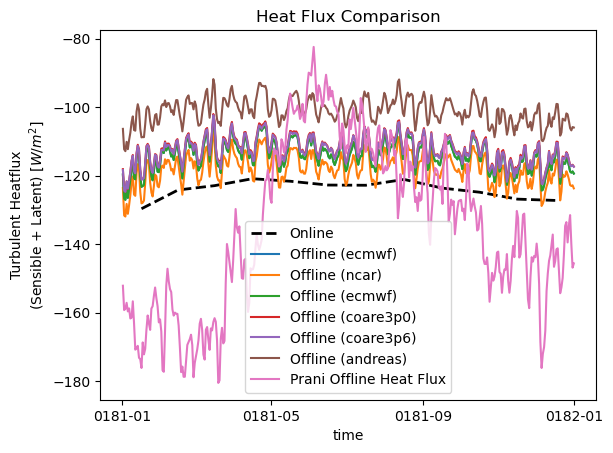

In [98]:
fig, ax = plt.subplots()

ds = full_flux["CM26"]["online"]["global_mean"]
da = add_total(ds)["q_total"]
da.plot(label="Online", ax=ax, lw=2, ls="--", color="k")

ds_offline = full_flux["CM26"]["offline"]["global_mean"]
da_offline = add_total(ds_offline)["q_total"]
da_offline.sel(algo='ecmwf').plot(label=f"Offline ({'ecmwf'})", ax=ax)

for algo in da_offline.algo.data:
    da_offline.sel(algo=algo).plot(label=f"Offline ({algo})", ax=ax)

HF_spatialAvg.plot(label='Prani Offline Heat Flux', ax=ax)

ax.set_title("Heat Flux Comparison")
ax.set_ylabel(label_dict["q_total"])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="best")


In [86]:
import gcsfs
import xarray as xr
path = "gs://cmip6/GFDL_CM2_6/control/ocean_boundary"
ds = xr.open_dataset(path, engine='zarr', chunks={})
ds

<xarray.Dataset> Size: 252GB
Dimensions:                    (time: 240, yu_ocean: 2700, xu_ocean: 3600,
                                yt_ocean: 2700, xt_ocean: 3600, nv: 2)
Coordinates:
    geolat_c                   (yu_ocean, xu_ocean) float32 39MB dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolat_t                   (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_c                   (yu_ocean, xu_ocean) float32 39MB dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t                   (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(338, 450), meta=np.ndarray>
  * nv                         (nv) float64 16B 1.0 2.0
  * time                       (time) object 2kB 0181-01-16 12:00:00 ... 0200...
  * xt_ocean                   (xt_ocean) float64 29kB -279.9 -279.8 ... 79.95
  * xu_ocean                   (xu_ocean) float64 29kB -279.9 -279.8 ... 80.0
  * yt_ocean                   (yt_ocean) float64 22kB -81.11 -81.07 ... 89.98
  * yu_ocean                   (yu_ocean) float64 22kB -81.09 -81.05 ... 90.0
Data variables: (12/27)
    bottom_power_u             (time, yu_ocean, xu_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    bottom_power_v             (time, yu_ocean, xu_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    calving_melt_heat          (time, yt_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ekman_heat                 (time, yu_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ekman_we                   (time, yu_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    evap                       (time, yt_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ...                         ...
    sfc_hflux_pme              (time, yt_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    swflx                      (time, yt_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    tau_x                      (time, yu_ocean, xu_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    tau_y                      (time, yu_ocean, xu_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind_power_u               (time, yu_ocean, xu_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind_power_v               (time, yu_ocean, xu_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    filename:   01810101.ocean_bdy_flux.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      CM2.6_miniBling

In [96]:
FF_CM26 = ds.evap.mean(dim=["xt_ocean", "yt_ocean"]).load()
FF_CM26 = FF_CM26.isel(time=slice(0,12))
FF_CM26

<xarray.DataArray 'evap' (time: 12)> Size: 48B
array([-2.7923712e-05, -2.7629882e-05, -2.7708089e-05, -2.7083166e-05,
       -2.6499034e-05, -2.5816928e-05, -2.5603076e-05, -2.5340267e-05,
       -2.6272075e-05, -2.6825368e-05, -2.6769545e-05, -2.6972546e-05],
      dtype=float32)
Coordinates:
  * time     (time) object 96B 0181-01-16 12:00:00 ... 0181-12-16 12:00:00

In [97]:
MomF_CM26 = np.sqrt( ds.tau_x ** 2 + ds.tau_y ** 2 )    
MF_CM26 = MomF_CM26.mean(dim=["xu_ocean", "yu_ocean"]).load()
MF_CM26 = MF_CM26.isel(time=slice(0,12))
MF_CM26

<xarray.DataArray (time: 12)> Size: 48B
array([0.07770471, 0.07816307, 0.07752577, 0.07337903, 0.07299916,
       0.07270807, 0.08129955, 0.07980188, 0.08325319, 0.08703149,
       0.06797787, 0.07077901], dtype=float32)
Coordinates:
  * time     (time) object 96B 0181-01-16 12:00:00 ... 0181-12-16 12:00:00

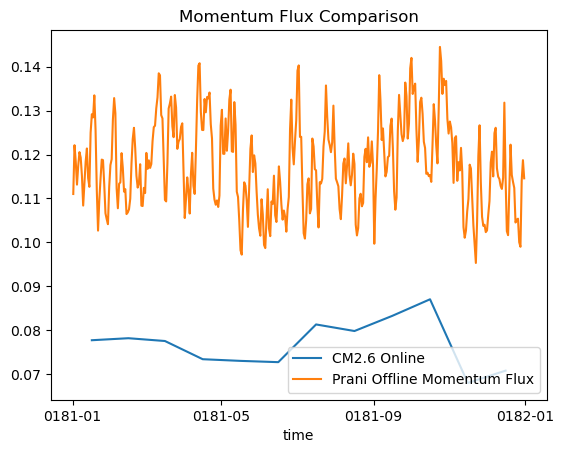

In [102]:
fig, ax = plt.subplots()

MF_CM26.plot(label=f"CM2.6 Online", ax=ax)

MF_spatialAvg.plot(label='Prani Offline Momentum Flux', ax=ax)

ax.set_title("Momentum Flux Comparison")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="best")


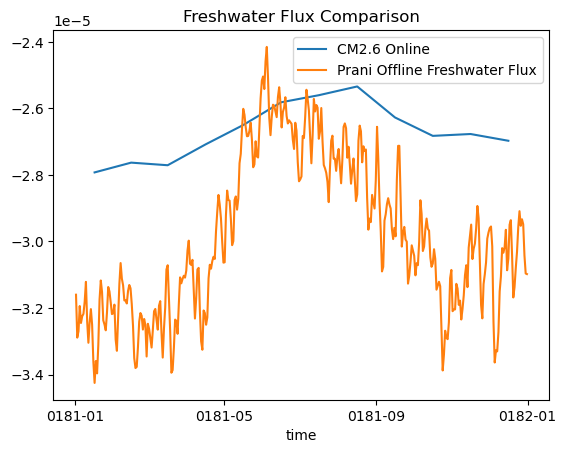

In [103]:
fig, ax = plt.subplots()

FF_CM26.plot(label=f"CM2.6 Online", ax=ax)

FF_spatialAvg.plot(label='Prani Offline Freshwater Flux', ax=ax)

ax.set_title("Freshwater Flux Comparison")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="best")
